In [1]:
# Các thư viện cần thiết
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams['figure.figsize'] = [20, 8]

In [2]:
# Đọc file dữ liệu
df = pd.read_csv('../../Dataset/Platinum.csv')
df.shape

(2344, 5)

In [3]:
# Kiểm tra cột close có hàng nào null không
df['Close'].isnull().sum()

0

In [4]:
# Đưa về kiểu date và đánh index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'])

# Sắp xếp lại index
df = df.sort_index(ascending=True)
df = df.drop(columns=['Open', 'High', 'Low'])
df

,Close
Date,
2018-01-01,930.5
2018-01-02,945.5
2018-01-03,957.0
2018-01-04,964.0
2018-01-05,969.5
...,...
2024-05-28,1059.5
2024-05-29,1040.5
2024-05-30,1031.5


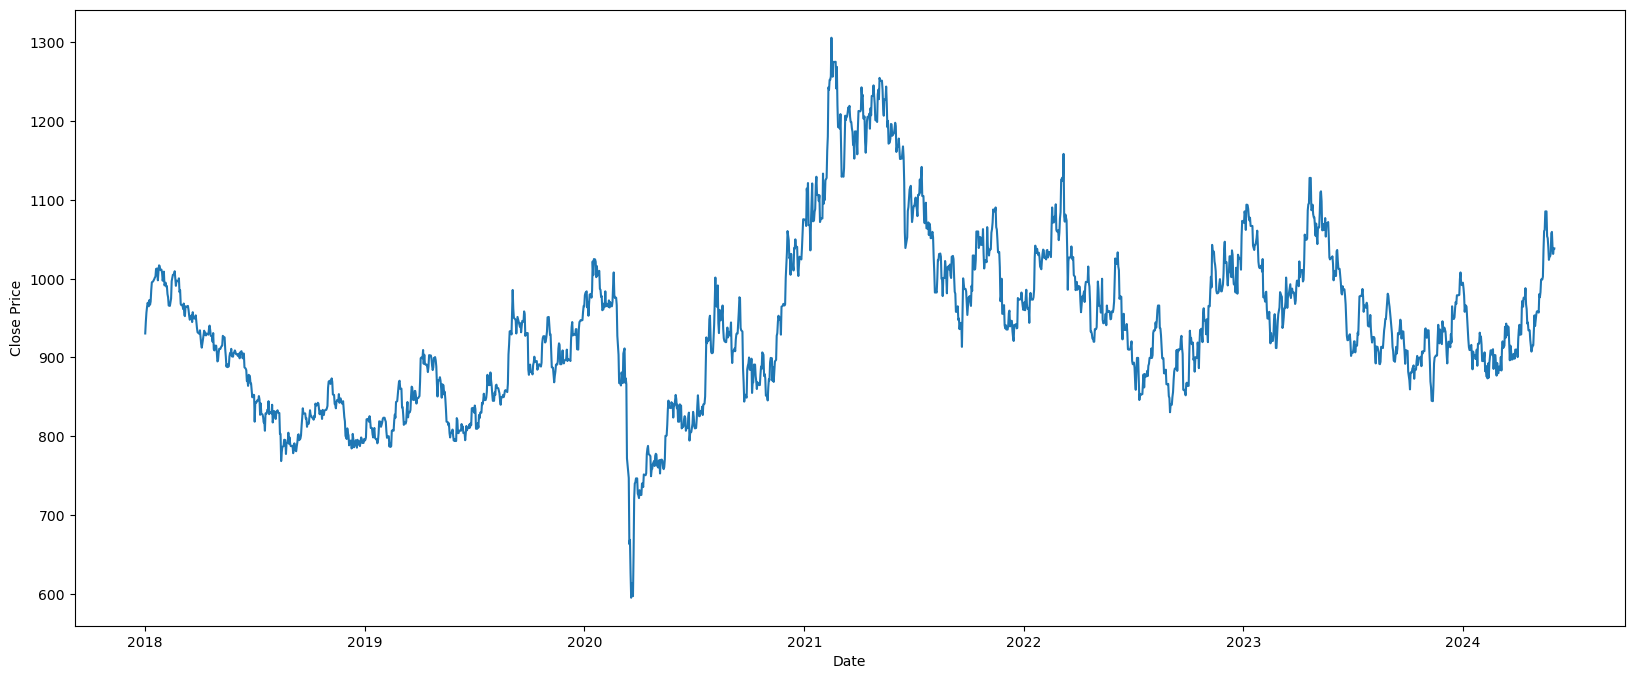

In [5]:
# Vẽ biểu đồ chuỗi thời gian
plt.plot(df)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [6]:
# Chia train test theo tỉ lệ
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [7]:
# Chia các tập x,y train, test tương ứng
x_train = np.array(train_data.index).reshape(-1, 1)  #Lấy chỉ mục Index
y_train = np.array(train_data['Close']) #Lấy dữ liệu giá Close

x_test = np.array(test_data.index).reshape(-1, 1)  #Lấy chỉ mục Index
y_test = np.array(test_data['Close']) #Lấy dữ liệu giá Close

In [8]:
# Quá trình training
# Tìm kiếm các tham số tốt nhất bằng auto_arima
model = ARIMA(y_train, order=(0, 1, 0))

# Fit mô hình với các tham số tốt nhất được tìm kiếm
fitted_model = model.fit()

In [9]:
# Tóm tắt model
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1875
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -7574.360
Date:                Thu, 13 Jun 2024   AIC                          15150.720
Time:                        16:33:34   BIC                          15156.255
Sample:                             0   HQIC                         15152.759
                               - 1875                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       189.7592      3.309     57.342      0.000     183.273     196.245
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1997.74
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.40   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# Quá trình testing 
y_pred = fitted_model.forecast(steps=len(x_test))

In [11]:
# Tính MSE - Mean Squared Error - Sai số bình phương trung bình
test_mse = mean_squared_error(y_test, y_pred) 
print('Testing MSE:', test_mse)

# Tính RMSE - Root Mean Squared Error - Sai số bình phương trung bình
test_rmse = math.sqrt(test_mse)
print('Testing RMSE:', test_rmse)

# Tính MAPE - Mean Absolute Percentage Error - Tỷ lệ phần trăm sai số tuyệt đối trung bình
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)

Testing MSE: 4389.925997607203
Testing RMSE: 66.25651664257036
Testing MAPE: 0.04771906846430689


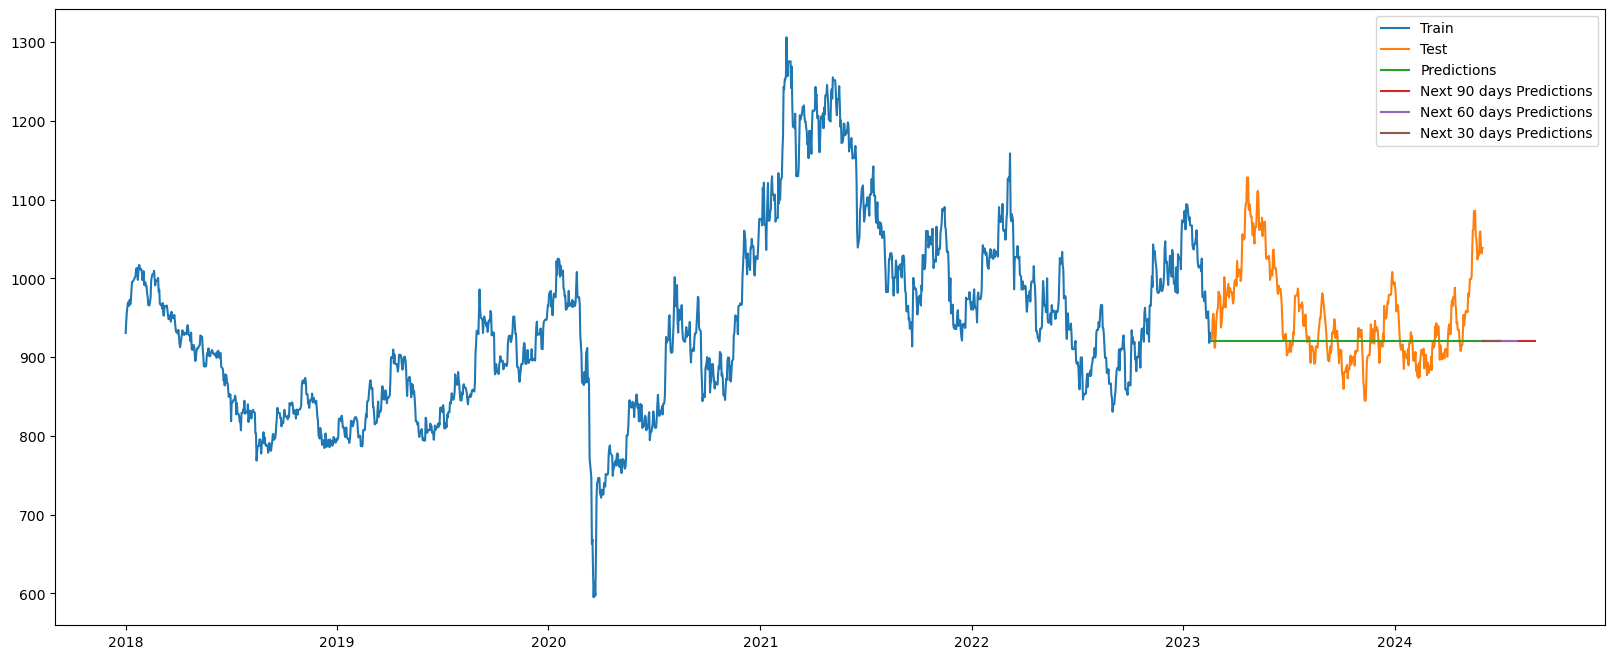

In [12]:
# Dự đoán 30
predict_days = 30
# Quá trình tạo index predict
date_range = pd.date_range(start = df.index[-1] + pd.DateOffset(days=1), end= df.index[-1] + pd.DateOffset(days=predict_days))
# Chuyển đổi sang NumPy array và reshape
x_next_30 = np.array(date_range).reshape(-1, 1)
# Tạo ra mảng dữ liệu dự đoán của y_next
y_next_30 = fitted_model.forecast(steps=len(x_next_30))

# Dự đoán 60
predict_days = 60
# Quá trình tạo index predict
date_range = pd.date_range(start = df.index[-1] + pd.DateOffset(days=1), end= df.index[-1] + pd.DateOffset(days=predict_days))
# Chuyển đổi sang NumPy array và reshape
x_next_60 = np.array(date_range).reshape(-1, 1)
# Tạo ra mảng dữ liệu dự đoán của y_next
y_next_60 = fitted_model.forecast(steps=len(x_next_60))

# Dự đoán 90
predict_days = 90
# Quá trình tạo index predict
date_range = pd.date_range(start = df.index[-1] + pd.DateOffset(days=1), end= df.index[-1] + pd.DateOffset(days=predict_days))
# Chuyển đổi sang NumPy array và reshape
x_next_90 = np.array(date_range).reshape(-1, 1)
# Tạo ra mảng dữ liệu dự đoán của y_next
y_next_90 = fitted_model.forecast(steps=len(x_next_90))

# Vẽ hình
plt.plot(x_train, y_train)
plt.plot(x_test, y_test)
plt.plot(x_test, y_pred)
plt.plot(x_next_90, y_next_90)
plt.plot(x_next_60, y_next_60)
plt.plot(x_next_30, y_next_30)
plt.legend(['Train', 'Test', 'Predictions', 'Next 90 days Predictions', 'Next 60 days Predictions', 'Next 30 days Predictions'])
plt.show()